Лучший результат получился на mobilevitv2, gan не помог улучшить скор (возможно из-за своей простоты и неспособности разнообразить выборку). 
Применяется несколько аугментаций, поскольку это улучшает скор.
Итоговый скор выбила 3 модель + 2 аугментации (уже выставлены в aug части)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display



import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset



import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau
from collections import defaultdict

import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob

from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau
from collections import defaultdict
import torch.nn.functional as F
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import seaborn as sns

import timm
from torchvision import models
import torch.nn as nn
import torch

/home/n03rrz/anaconda3/envs/dl_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/n03rrz/anaconda3/envs/dl_env/lib/python3.13/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Research

Total folders: 103 



,class_number,files
0,94,110
1,19,87
2,6,123
3,5,45
4,14,50
...,...,...
95,55,76
96,54,117
97,74,138
98,2,143


['94' '19' '6' '5' '14' '82' '1' '87' '89' '41' '77' '78' '51' '80' '39'
 '70' '72' '43' '42' '96' '21' '44' '62' '36' '90' '25' '61' '86' '99'
 '85' '26' '58' '71' '30' '98' '92' '32' '3' '65' '95' '22' '50' '11' '49'
 '40' '83' '31' '93' '35' '64' '73' '23' '48' '4' '97' '69' '27' '33' '15'
 '24' '46' '63' '52' '66' '37' '10' '16' '18' '79' '20' '56' '53' '60' '0'
 '13' '28' '45' '84' '76' '68' '34' '17' '8' '57' '91' '47' '7' '75' '88'
 '29' '38' '59' '12' '81' '67' '55' '54' '74' '2' '9']


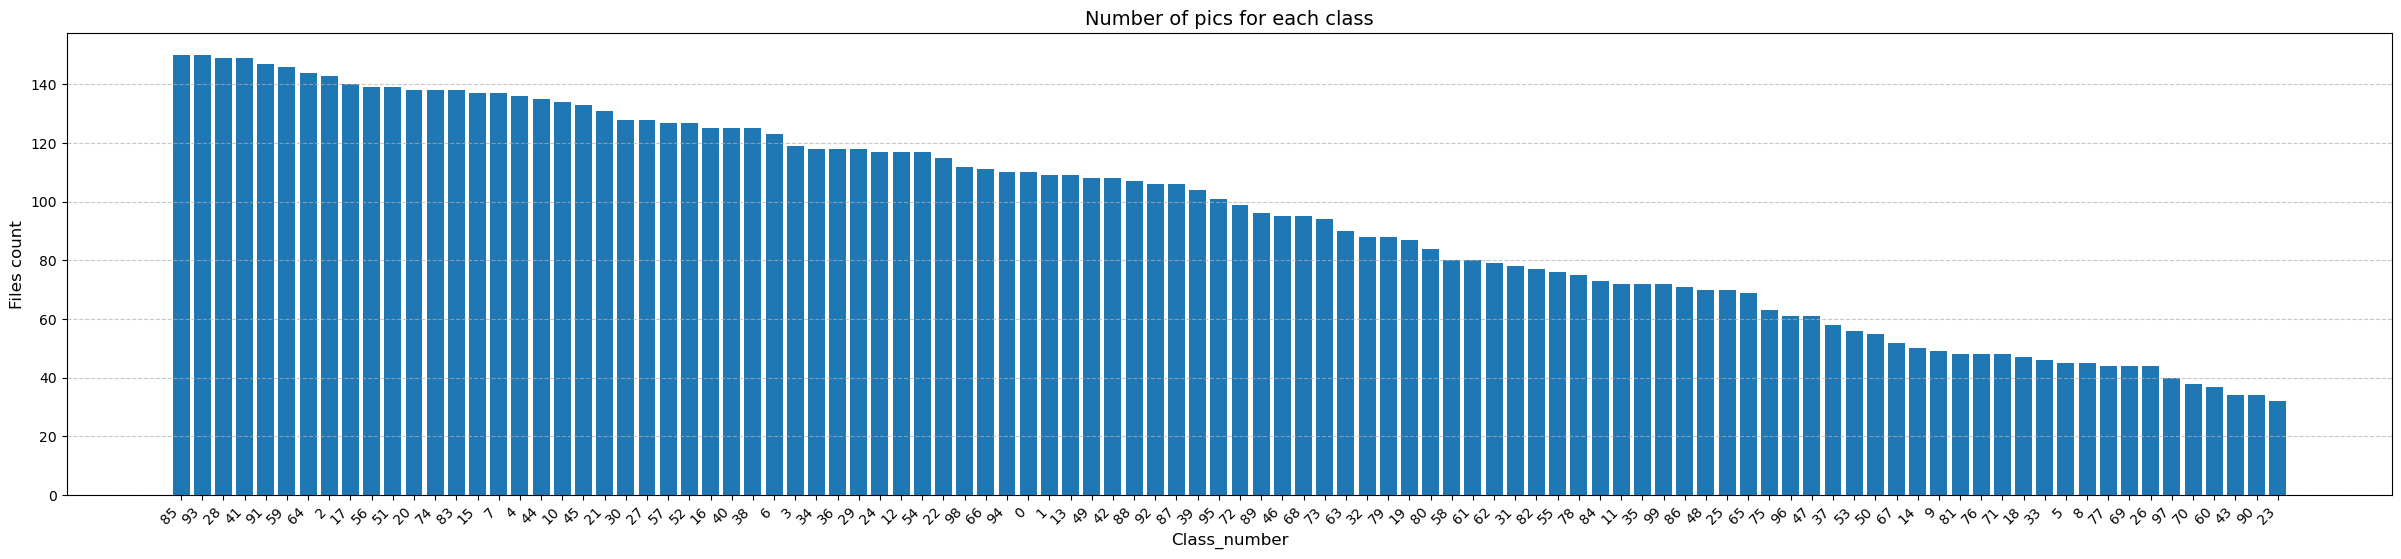

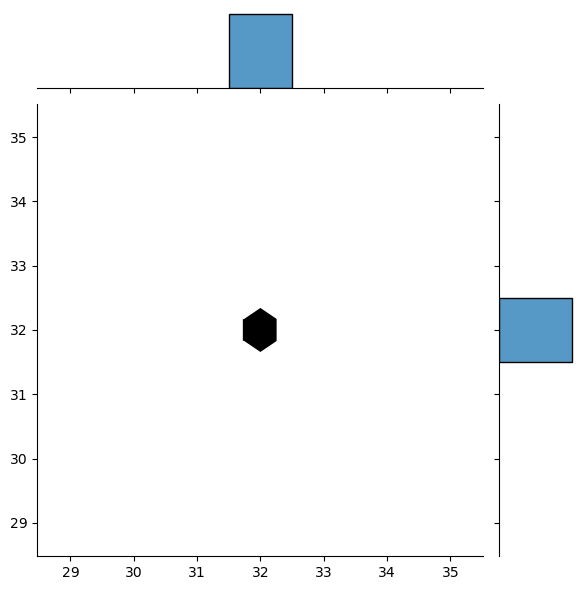

In [2]:
folder_path = 'dl-2025-competition-1/data/train'

total_subdirs = 0
files_per_subdir = {}

for root, dirs, files in os.walk(folder_path):
    if root != folder_path:
        total_subdirs += 1
        subdir_name = os.path.basename(root)
        files_count = len(files)
        files_per_subdir[subdir_name] = [files_count]

print(f"Total folders: {total_subdirs} \n")

datafr = pd.DataFrame(data=files_per_subdir).T
datafr.rename(columns={0:"files"}, inplace=True)
datafr.drop(index=".ipynb_checkpoints", inplace=True)
datafr.reset_index(names="class_number", inplace=True)
datafr_sorted = datafr.sort_values("files", ascending=False)
display(datafr)
print(datafr["class_number"].unique())
plt.figure(figsize=(30, 6))
plt.bar(datafr_sorted["class_number"], datafr_sorted["files"])
plt.title("Number of pics for each class", fontsize=14)
plt.xlabel("Class_number", fontsize=12)
plt.ylabel("Files count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

widths, heights = [], []
for img_path in os.listdir("dl-2025-competition-1/data/train/85"):
    with Image.open(os.path.join("dl-2025-competition-1/data/train/85", img_path)) as img:
        widths.append(img.width)
        heights.append(img.height)
sns.jointplot(x=widths, y=heights, kind='hex')

Получается, что число примеров не одинаково для каждого класса, где-то мы имеем больше примеров, где-то меньше.
Больше всего примеров кроватей (85), меньше всего крабов (23). Можно ожидать, что мы хуже будем распозновать крабов (23), жуков (90), змей (43) и другие малочисленные классы, возможно стоит больше времени уделить именно аугментации этих классов.
Стоит отметить, что примеры имеют различные происхождения. Это могут фотографии без дополнительной обрабоки, могут быть обработанные (например вырезаны другие объекты), рисунки, иконки и т.д.

### Loader

In [2]:
train_transform_1 = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # A.RandomBrightnessContrast(p=0.3),
    A.OneOf([
        A.ChannelDropout(p=0.5),
        A.ToGray(p=0.5),
        # A.Posterize(num_bits=2, p=0.5),
        # A.ColorJitter(p=0.5)
    ], p=0.5),
    # A.OneOf([
    #     A.RandomBrightnessContrast(p=0.5),
    #     # A.HueSaturationValue(p=0.5),
    #     A.GaussianBlur(p=0.3),
    #     # A.RandomGamma(p=0.3),
    #     # A.Blur(blur_limit=3, p=0.3),
    #     # A.UnsharpMask(p=0.5),
    #     # A.ImageCompression(p=0.5)
    # ], p=0.2),
    A.OneOf([
        A.GaussNoise(p=0.5, std_range=(0.01, 0.05)),
        # A.Superpixels(p=0.5),
        A.PixelDropout(p=0.5),
        # A.MultiplicativeNoise(p=0.5)
    ], p=0.75),
    # A.RandomCrop(width=16, height=16, p=0.3),
    # Real World Training, Uncomment Below
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # A.Normalize(),
    ToTensorV2()
])

train_transform_orig = A.Compose([A.Resize(224, 224), A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()])

def train_orig(image):
    image_np = np.array(image)
    augmented = train_transform_orig(image=image_np)
    return augmented["image"]

class CustomConcatDataset(ConcatDataset):
    def __init__(self, datasets):
        super().__init__(datasets)
        if hasattr(datasets[0], 'classes'):
            self.classes = datasets[0].classes
            self.class_to_idx = datasets[0].class_to_idx
            self.targets = []
            for ds in datasets:
                if hasattr(ds, 'targets'):
                    self.targets.extend(ds.targets)

class AlbumentationsDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if isinstance(image, torch.Tensor):
            image = image.numpy().transpose(1, 2, 0)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image.transpose(2, 0, 1))
        
        return image, label

class Dataset_1(Dataset):
    def __init__(self, split='train', transform=None, root_dir="dl-2025-competition-1/data/"):
        self.transform = transform
        self.samples = []
        
        if split in ['train', 'val']:
            for cl in range(100):
                cl_w = os.path.join(root_dir, 'train', str(cl))
                file = sorted(glob.glob(os.path.join(cl_w, '*')))
                train_files, val_files = train_test_split(file, test_size=0.2)
                
                if split == 'train':
                    selected_files = train_files
                else:
                    selected_files = val_files
                
                for file in selected_files:
                    self.samples.append((file, cl))
                    
        else:
            test_dir = os.path.join(root_dir, 'test')
            file = glob.glob(os.path.join(test_dir, '*'))
            file.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
            for fl in file:
                self.samples.append((fl, -1))
            
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        
        if image is None:
            print(f"Не удалось загрузить изображение: {img_path}")
            new_idx = (idx + 1) % len(self.samples)
            return self.__getitem__(new_idx)
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image_pil = Image.fromarray(image)
            image = train_orig(image_pil)
            
        return image, label


train_dataset_1 = Dataset_1(split='train', transform=train_orig)
val_dataset = Dataset_1(split='val', transform=train_orig)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)

### Augmentation application

#### GAN

In [5]:
# GAN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
n_classes = 100
img_size = 224
channels = 3
batch_size = 32
embed_dim = 50

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.label_embed = nn.Sequential(
            nn.Embedding(n_classes, embed_dim),
            nn.Linear(embed_dim, 16)
        )

        self.model = nn.Sequential(
            nn.Linear(latent_dim + 16, 512 * 14 * 14),
            nn.Unflatten(1, (512, 14, 14)),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, channels, 5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embed = self.label_embed(labels).view(noise.size(0), -1)
        gen_input = torch.cat((noise, label_embed), dim=1)
        return self.model(gen_input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.label_embed = nn.Sequential(
            nn.Embedding(n_classes, embed_dim),
            nn.Linear(embed_dim, 224*224)
        )

        self.model = nn.Sequential(
            nn.Conv2d(channels + 1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 5, stride=2, padding=2),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Linear(512*14*14, 1)
        )

    def forward(self, img, labels):
        label_embed = self.label_embed(labels).view(img.size(0), 1, img_size, img_size)
        d_input = torch.cat((img, label_embed), dim=1)
        return self.model(d_input).view(-1)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()
scheduler_G = optim.lr_scheduler.ExponentialLR(optimizer_G, gamma=0.95)
scheduler_D = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=0.95)

def train(epochs, dataloader):
    for epoch in range(epochs):
        for i, (imgs, labels) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            labels = labels.to(device)
            noise = torch.randn(imgs.size(0), latent_dim).to(device)
            gen_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)
            fake_imgs = generator(noise, gen_labels)
            optimizer_D.zero_grad()
            real_pred = discriminator(real_imgs, labels)
            real_loss = criterion(real_pred, torch.ones_like(real_pred))
            fake_pred = discriminator(fake_imgs.detach(), gen_labels)
            fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
            
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            optimizer_G.zero_grad()
            gen_pred = discriminator(fake_imgs, gen_labels)
            g_loss = criterion(gen_pred, torch.ones_like(gen_pred))
            g_loss.backward()
            optimizer_G.step()

def generate_dataset():
    generator.eval()
    dataset = []
    for class_id in range(n_classes):
        for _ in range(20):
            noise = torch.randn(1, latent_dim).to(device)
            label = torch.tensor([class_id]).to(device)
            with torch.no_grad():
                gen_img = generator(noise, label).cpu()
            dataset.append((gen_img.squeeze(0), class_id))
    return dataset


transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train(epochs=3, dataloader=train_loader_1)

generated_dataset = generate_dataset()

#### AUG

In [3]:
# Unomment this for generation
# print("before",len(train_dataset_1))
# train_dataset_1 = CustomConcatDataset([train_dataset_1, generated_dataset])
# print("after",len(train_dataset_1))
# Uncomment this for more augmentation
train_dataset_aug_1 = AlbumentationsDataset(train_dataset_1, transform=train_transform_1)
train_dataset_aug_2 = AlbumentationsDataset(train_dataset_1, transform=train_transform_1)

train_dataset_1 = CustomConcatDataset([train_dataset_1, train_dataset_aug_1])
train_dataset_1 = CustomConcatDataset([train_dataset_1, train_dataset_aug_2])
train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)

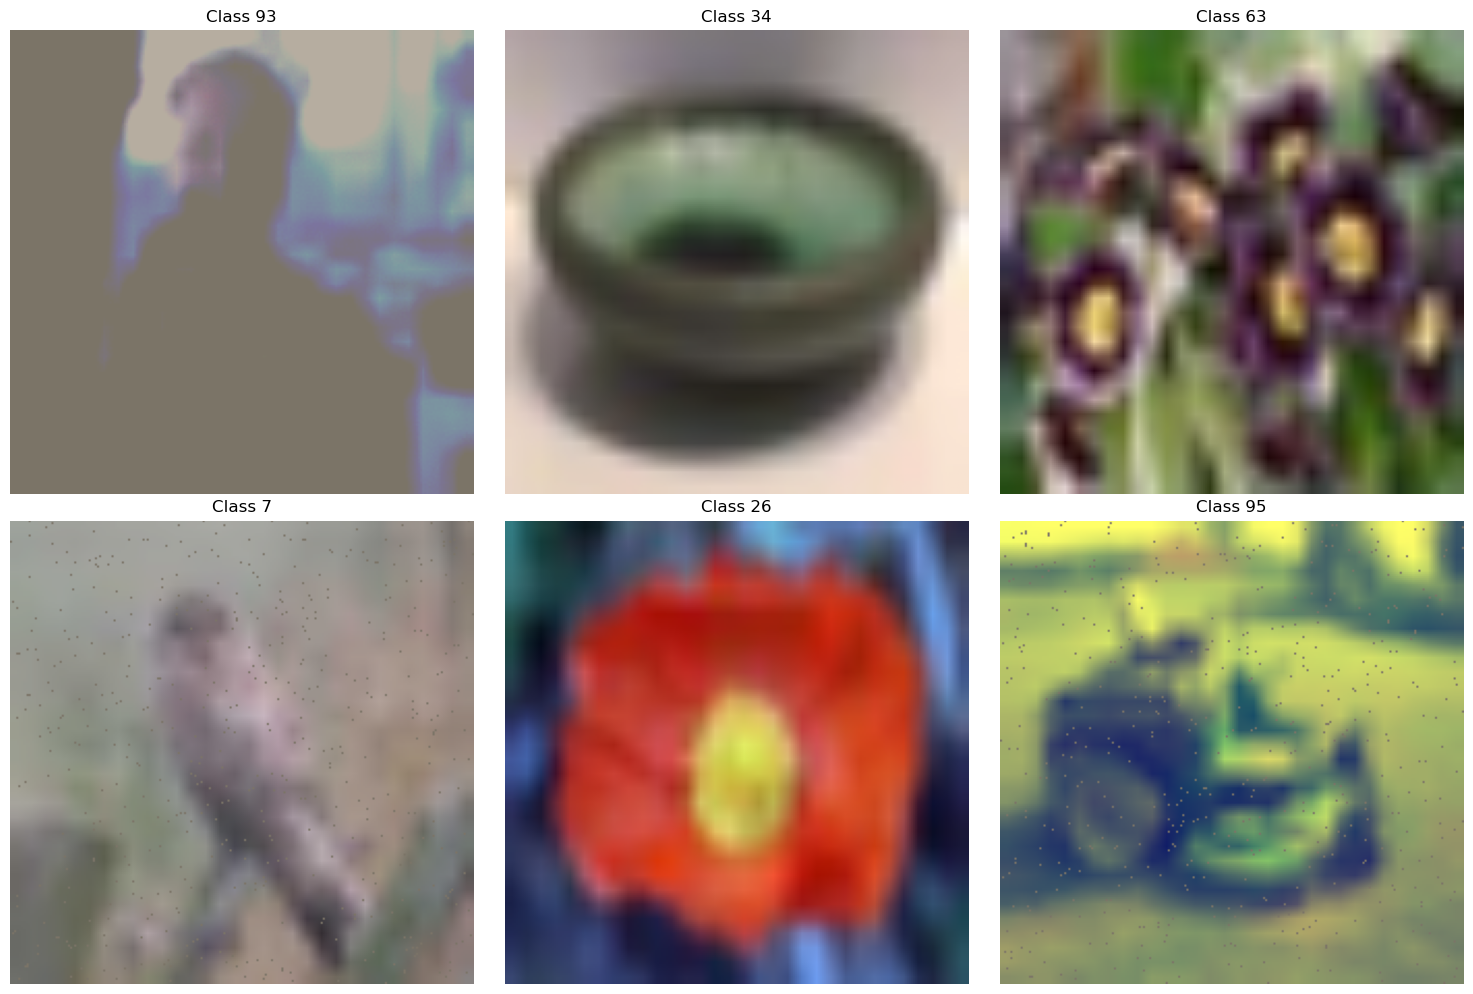

In [4]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def show_images_d(dataset, num_images=6, classes=None):
    indices = np.random.choice(len(dataset), num_images, replace=False)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        if isinstance(image, torch.Tensor):
            image = denormalize(image).cpu()
            image = image.numpy().transpose((1, 2, 0))
            image = np.clip(image, 0, 1)
        if classes:
            label_text = classes[label]
        else:
            label_text = f"Class {label}"
        plt.subplot(2, 3, i+1)
        plt.imshow(image)
        plt.title(label_text, fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images_d(train_dataset_1, num_images=6)

### Model_1 (without transfer learning)

Epoch 1
Train Loss: 4.4100 | Val Loss: 3.9811
Train Acc: 0.0480 | Val Acc: 0.1223
LR: 0.000280

Epoch 2
Train Loss: 4.0912 | Val Loss: 3.7836
Train Acc: 0.0831 | Val Acc: 0.1455
LR: 0.000460

Epoch 3
Train Loss: 4.0335 | Val Loss: 3.5939
Train Acc: 0.0893 | Val Acc: 0.1662
LR: 0.000640

Epoch 4
Train Loss: 3.8534 | Val Loss: 3.4571
Train Acc: 0.1170 | Val Acc: 0.1842
LR: 0.000820

Epoch 5
Train Loss: 3.7702 | Val Loss: 3.3007
Train Acc: 0.1275 | Val Acc: 0.2095
LR: 0.001000



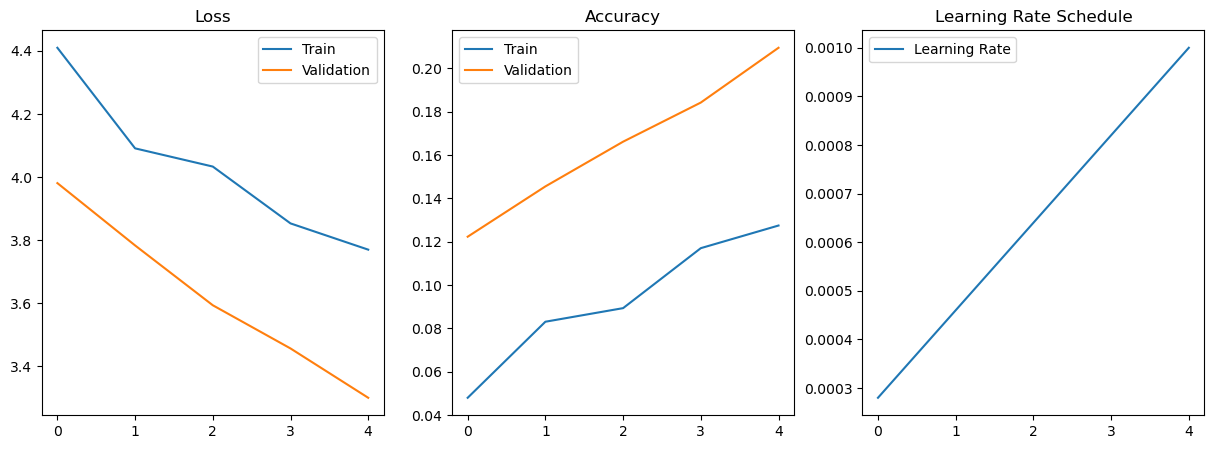

In [10]:
class MyModel(nn.Module):
    def __init__(self, num_classes=100):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = x.float()  
        x = self.features(x)
        x = self.classifier(x)
        return x

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler_warmup = LinearLR(optimizer, start_factor=0.1, total_iters=5)
scheduler_main = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
early_stopping = EarlyStopping(patience=3)



best_val_loss = float('inf')
history = defaultdict(list)

for epoch in range(5):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader_1:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    train_loss = train_loss / total
    train_acc = correct / total
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    if epoch < 5:
        scheduler_warmup.step()
    else:
        scheduler_main.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"LR: {history['lr'][-1]:.6f}\n")


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

### Model_2 (with transfer learingn)(mobilenet_v3_small)

/home/n03rrz/anaconda3/envs/dl_env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/n03rrz/anaconda3/envs/dl_env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1
Train Loss: 4.3401 | Val Loss: 3.6582
Train Acc: 0.0728 | Val Acc: 0.3142
LR: 0.000280

Epoch 2
Train Loss: 3.4592 | Val Loss: 2.4367
Train Acc: 0.2560 | Val Acc: 0.5186
LR: 0.000460

Epoch 3
Train Loss: 2.7931 | Val Loss: 1.7834
Train Acc: 0.3706 | Val Acc: 0.6099
LR: 0.000640

Epoch 4
Train Loss: 2.4843 | Val Loss: 1.4686
Train Acc: 0.4120 | Val Acc: 0.6507
LR: 0.000820

Epoch 5
Train Loss: 2.3119 | Val Loss: 1.2388
Train Acc: 0.4441 | Val Acc: 0.6811
LR: 0.001000

Epoch 6
Train Loss: 2.2239 | Val Loss: 1.1335
Train Acc: 0.4499 | Val Acc: 0.6997
LR: 0.001000

Epoch 7
Train Loss: 2.1411 | Val Loss: 1.0231
Train Acc: 0.4697 | Val Acc: 0.7276
LR: 0.000999

Epoch 8
Train Loss: 2.0634 | Val Loss: 0.9256
Train Acc: 0.4856 | Val Acc: 0.7663
LR: 0.000998

Epoch 9
Train Loss: 2.0078 | Val Loss: 0.8869
Train Acc: 0.4969 | Val Acc: 0.7745
LR: 0.000996

Epoch 10
Train Loss: 1.9642 | Val Loss: 0.8073
Train Acc: 0.5054 | Val Acc: 0.7900
LR: 0.000993

Epoch 11
Train Loss: 1.8979 | Val Loss:

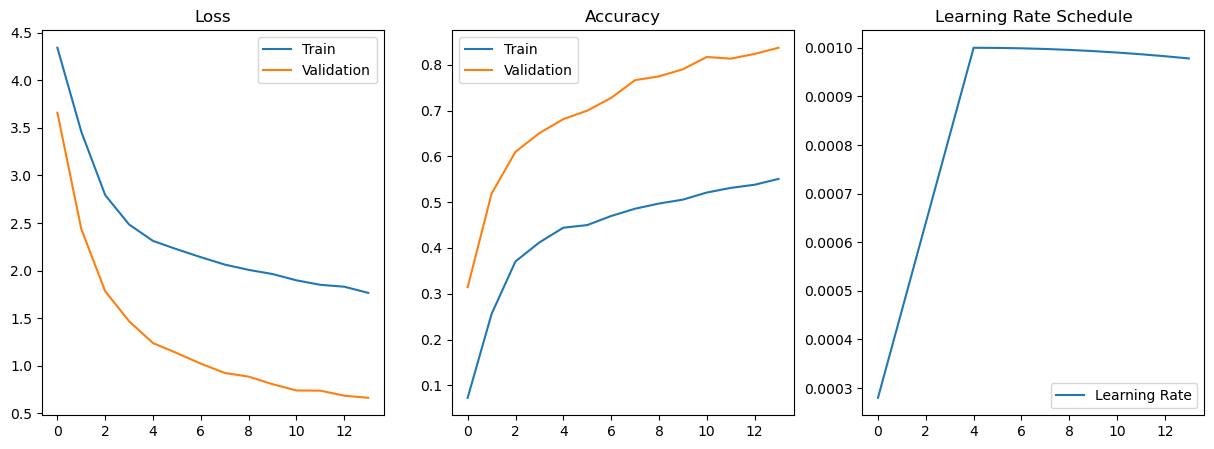

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#mobilenet_v3_small
import torchvision.models as models

backbone = models.mobilenet_v3_small(pretrained=True)
for param in backbone.parameters():
    param.requires_grad = False
num_features = 576
num_classes = 100

head = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)

class FinalModel(nn.Module):
    def __init__(self, backbone, head):
        super(FinalModel, self).__init__()
        self.backbone_features = backbone.features
        self.backbone_avgpool = backbone.avgpool
        self.head = head
        
    def forward(self, x):
        x = self.backbone_features(x)
        x = self.backbone_avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return x

mobnetv3s = FinalModel(backbone, head).to(device)


class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mobnetv3s = FinalModel(backbone, head).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobnetv3s.parameters(), lr=0.001)
scheduler_warmup = LinearLR(
    optimizer, 
    start_factor=0.1,
    total_iters=5
)
scheduler_cosine = CosineAnnealingLR(
    optimizer,
    T_max=95,
    eta_min=1e-6
)
scheduler = SequentialLR(
    optimizer,
    schedulers=[scheduler_warmup, scheduler_cosine],
    milestones=[5]
)
early_stopping = EarlyStopping(patience=3)



best_val_loss = float('inf')
history = defaultdict(list)

for epoch in range(14):
    mobnetv3s.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader_1:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = mobnetv3s(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    mobnetv3s.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = mobnetv3s(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    train_loss = train_loss / total
    train_acc = correct / total
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(mobnetv3s.state_dict(), 'mobnetv3s.pth')
    
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"LR: {history['lr'][-1]:.6f}\n")


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

### Model_3 best (with transfer learning)(mobilevitv2)

Epoch 1
Train Loss: 4.3587 | Val Loss: 3.1132
Train Acc: 0.0630 | Val Acc: 0.3813
LR: 0.000280

Epoch 2
Train Loss: 3.3830 | Val Loss: 1.4972
Train Acc: 0.2283 | Val Acc: 0.6249
LR: 0.000460

Epoch 3
Train Loss: 2.8698 | Val Loss: 1.0026
Train Acc: 0.3208 | Val Acc: 0.7286
LR: 0.000640

Epoch 4
Train Loss: 2.6526 | Val Loss: 0.8040
Train Acc: 0.3610 | Val Acc: 0.7719
LR: 0.000820

Epoch 5
Train Loss: 2.5293 | Val Loss: 0.7241
Train Acc: 0.3842 | Val Acc: 0.7951
LR: 0.001000

Epoch 6
Train Loss: 2.4377 | Val Loss: 0.6678
Train Acc: 0.4024 | Val Acc: 0.8019
LR: 0.001000

Epoch 7
Train Loss: 2.3072 | Val Loss: 0.6343
Train Acc: 0.4288 | Val Acc: 0.8189
LR: 0.000999

Epoch 8
Train Loss: 2.1502 | Val Loss: 0.5525
Train Acc: 0.4607 | Val Acc: 0.8504
LR: 0.000998

Epoch 9
Train Loss: 2.0024 | Val Loss: 0.4973
Train Acc: 0.4908 | Val Acc: 0.8643
LR: 0.000996

Epoch 10
Train Loss: 1.8726 | Val Loss: 0.4880
Train Acc: 0.5211 | Val Acc: 0.8787
LR: 0.000993

Epoch 11
Train Loss: 1.7245 | Val Loss:

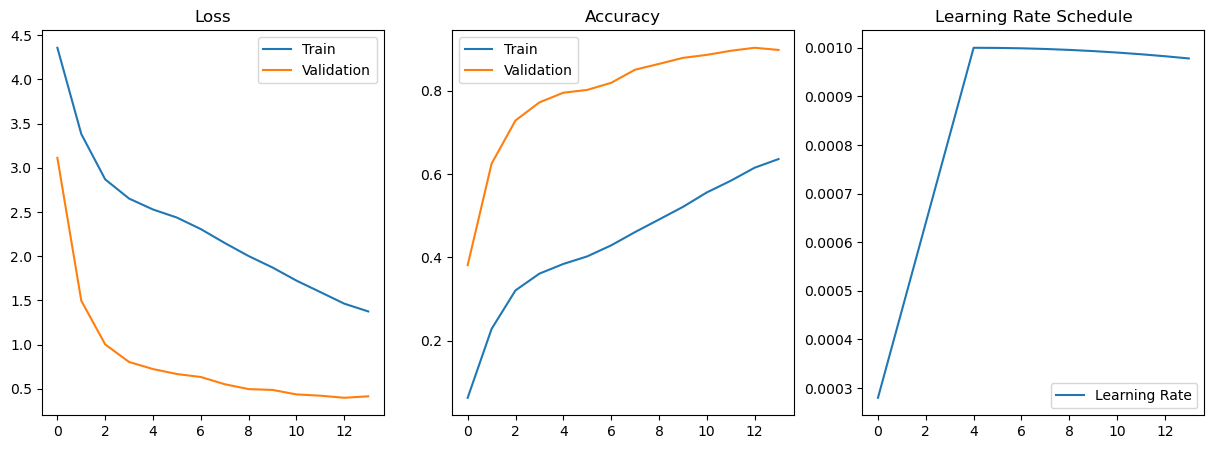

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#mobilevitv2
backbone = timm.create_model(
    'mobilevitv2_050',
    pretrained=True,
    num_classes=0,
    global_pool='avg'
)

dummy_input = torch.randn(1, 3, 224, 224)
with torch.no_grad():
    features = backbone(dummy_input)
num_features = features.shape[1]
num_classes = 100

head = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)

class FinalModel(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

mobilevitv2 = FinalModel(backbone, head).to(device)


class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mobilevitv2 = FinalModel(backbone, head).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilevitv2.parameters(), lr=0.001)
scheduler_warmup = LinearLR(
    optimizer, 
    start_factor=0.1,
    total_iters=5
)
scheduler_cosine = CosineAnnealingLR(
    optimizer,
    T_max=95,
    eta_min=1e-6
)
scheduler = SequentialLR(
    optimizer,
    schedulers=[scheduler_warmup, scheduler_cosine],
    milestones=[5]
)
early_stopping = EarlyStopping(patience=3)



best_val_loss = float('inf')
history = defaultdict(list)

for epoch in range(14):
    mobilevitv2.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader_1:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = mobilevitv2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    mobilevitv2.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = mobilevitv2(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    train_loss = train_loss / total
    train_acc = correct / total
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(mobilevitv2.state_dict(), 'mobilevitv2.pth')
    
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"LR: {history['lr'][-1]:.6f}\n")


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

### Kaggle result

In [15]:
kaggle_dataset = Dataset_1(split='test', transform=train_transform_orig)
kaggle_loader = DataLoader(kaggle_dataset, batch_size=32, shuffle=False)

predictions = []
file_ids = []
model = mobilevitv2
model.load_state_dict(torch.load('mobilevitv2.pth'))
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, _ in kaggle_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        predictions.extend(preds.cpu().numpy())

file_ids = [os.path.basename(x[0]).split('.')[0] for x in kaggle_dataset.samples]

results = pd.DataFrame({
    'id': file_ids,
    'target': predictions
})

results.to_csv('tl_mobnetv2_best_1.csv', index=False)